# PRV analysis

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
import pandas as pd

# nicec plot style
plt.style.use('ggplot')

sys.path.insert(0, os.path.abspath('../lib'))
import file_read
import sig_proc as sp
import hrv


def quality_inspection(filt_ppg, sr, pulse_loc, xcorr_thr=0.8, num_tm=5):
    tm_initial_flag = False
    num_pulse = len(pulse_loc)
    hq_idx = np.zeros(num_pulse)
    r = np.zeros(num_pulse)
    duration = np.zeros(num_pulse)
    for n in range(num_pulse):
        tr1_loc = pulse_loc[n][0]
        tr2_loc = pulse_loc[n][2]
        duration[n] = tr2_loc- tr1_loc
    
    # Dynamic set the length of template
    # template_length = int(np.median(duration))
    template_length = 40
    max_len = 240/60 # minimum HR 240
    min_len = 40/60 # minimum HR 40
    if template_length > sr*max_len:
        template_length = int(sr*max_len)
    elif template_length < sr*min_len:
        template_length = int(sr*min_len)
    # Template Initial
    tm_list = []
    
    fix_pulse_list = np.zeros((num_pulse, template_length))
    for n in range(num_pulse):
        single_pulse= sp.single_pulse_tailor(pulse_loc[n], filt_ppg, template_length)
        fix_pulse_list[n] = single_pulse
        
        if n == 0:
            ref_pulse = single_pulse
        else:
            test_pulse = single_pulse
        
            # Pulse similarity inspection using cross correlation 
            xcorr = sp.corrcoef(test_pulse, ref_pulse)
            r[n] = xcorr
            # Store the index of good quality pulse
            if xcorr > xcorr_thr:
                if xcorr>0.8:
                    hq_idx[n]=1
                # tm_list.append(test_pulse)       
                
            # update previous pulse
            ref_pulse = test_pulse   
    # if len(tm_list)> num_tm:
    #     avg_tm = np.mean(tm_list, 0)
    #     for n in range(num_pulse):
    #         xcorr2 = sp.corrcoef(fix_pulse_list[n], avg_tm)
    #         r[n] = xcorr2

    #         if xcorr2>0.8:
    #             hq_idx[n]=1
    return hq_idx, r



def correct_interval(pulse_loc, hq_idx):
    
    num_pulse = len(pulse_loc)
    peak_locs = [pulse_loc[i][1] for i in range(len(pulse_loc))]
    
    ibi = ((np.diff(peak_locs)) /sr)*1000
    correct_ibi = np.zeros(num_pulse-1)
    # print('length of rr:{}, number of pulse:{}'.format(len(ibi), num_pulse))
    # median filter length
    
    w = 7
    l = int(w/2)
    N = len(ibi)
    if sum(hq_idx) < 0.7*num_pulse:
        is_check=0
        correct_ibi=np.copy(ibi)
        
        # raise Exception('Ectopic interbeat intervals are more than 30%!')
        return ibi, correct_ibi, is_check
    else:
        is_check =1
        correct_ibi=np.copy(ibi)
        
        for i in range(N):
            j = i+1 # pulse index
            if hq_idx[j] == 0:
                if i < l:
                    correct_ibi[i] = np.median(ibi[0:w])
                elif i > len(ibi) -l:
                    correct_ibi[i] = np.median(ibi[N-w:len(rr)-1])
                else:
                    correct_ibi[i] = np.median(ibi[i-l:i+l+1])

        correct_ibi[np.abs(sp.z_score(correct_ibi))>2] = np.median(correct_ibi)
  
        return ibi , correct_ibi, is_check




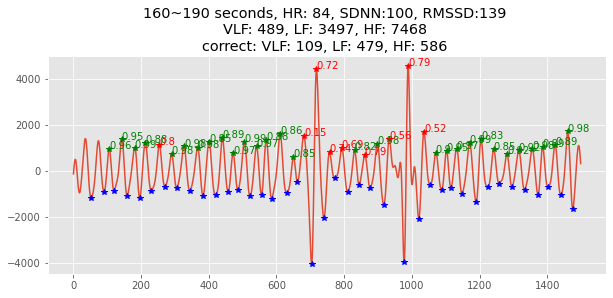

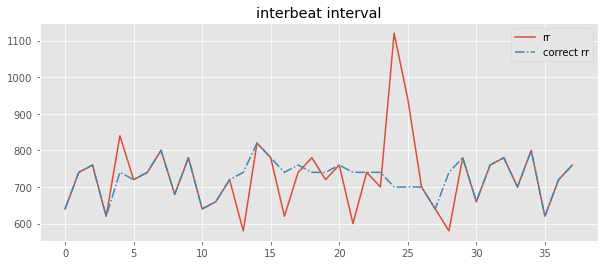

In [12]:
import pyhrv.frequency_domain as fd


# sampling
sr =50
# shift = sr*15

# Filter parameters
b, a = sp.bp_filter(0.8, 3, sr, 4)

vital_sign = {
    'subject': [],
    'HR': [],
    'correct HR':[],
    'SDNN':[],
    'correct SDNN':[],
    'RMSSD':[],
    'correct RMSSD':[],
    'VLF':[],
    'correct VLF':[],
    'LF':[],
    'correct LF':[],
    'HF':[],
    'correct HF':[],
}



# specific data path
file_name = '2022-4-14_11-14-10_T2-03-bf1730_RawData.csv'
data = file_read.thor2_reader('../../data/' + file_name)

''' 
data dictionary format
data = {
    "PPG_G1": [],
    "PPG_G2": [],...
}
'''

G2 = data['PPG_G2']
start_sec = 160
step_sec = 30
# reading total data
# end_sec = int(len(G2)/sr)
end_sec = 190

window_sec = 30 
window = sr*window_sec

for sec in range(start_sec, end_sec, step_sec):
    s1 = sec*sr
    s2 = s1+window    
    G2_time = np.arange(s1,s2)
    G2_sample = np.array(G2[s1:s2])
    
    '''init '''
    HR_list = []
    RMSSD_list = []
    
    RMSSD_c_list = []
    HR_c_list = []
    
    # -------------------------------------------------------------
    # Preprocessing
    # include following step
    # 1. flip up and down (if flip=1)
    # 2. bandpass filter
    # 3. normalize (if norm=1)
    

    filt_G2 = signal.filtfilt(b,a, G2_sample)
    filt_G2 = np.array(filt_G2)

    pks_loc, trs_loc = sp.find_peak_valley(sr, filt_G2)

    # filt_G2 = np.array(list(map(sp.value_trans, filt_G2)))
    # filt_G2 = filt_G2 + abs(min(filt_G2))
    
    # filt_G2 = sp.flip_up_down(G2_sample)
    # --------------------------------------------------------------

    '''PPG periodic inspection'''
    pulse_loc = sp.pulse_seg(pks_loc, trs_loc)
    hq_idx, relate= quality_inspection(filt_G2, sr, pulse_loc, xcorr_thr=0.8)
    

    peak_locs = [pulse_loc[i][1] for i in range(len(pulse_loc))]
    rr = ((np.diff(peak_locs)) /sr)*1000
    
    # correct_rr, hrv_flag = rr_editing(rr)
    # rr = hrv.preprocess(sr, filt_G2)
    rr, correct_rr, hrv_flag = correct_interval(pulse_loc, hq_idx)

    '''PRV time domain '''
    tdresults = hrv.timedomain(rr)
    HR = int(tdresults['Mean HR (beats/min)'] +0.5)
    RMSSD = int(tdresults['RMSSD (ms)'] +0.5)
    SDNN = int(tdresults['SDNN (ms)'] +0.5)

    '''PRV frequency domain '''
    freqresults, fxx, pxx = hrv.freqdomain(rr)
    VLF = int(freqresults['Power VLF (ms2)'].real)
    LF = int(freqresults['Power LF (ms2)'].real)
    HF = int(freqresults['Power HF (ms2)'].real)
    
    ''' correct PRV time and frequency domain result'''
    if hrv_flag:
        tdresult_correct = hrv.timedomain(correct_rr)
        HR_correct = int(tdresult_correct['Mean HR (beats/min)'] +0.5)
        RMSSD_correct = int(tdresult_correct['RMSSD (ms)']+0.5)
        SDNN_correct = int(tdresult_correct['SDNN (ms)']+0.5)

        freqresults_correct, _, _= hrv.freqdomain(correct_rr)
        VLF_correct = int(freqresults_correct['Power VLF (ms2)'].real)
        LF_correct = int(freqresults_correct['Power LF (ms2)'].real)
        HF_correct = int(freqresults_correct['Power HF (ms2)'].real)
    else:
        HR_correct = None
        RMSSD_correct = None
        SDNN_correct = None
        
        VLF_correct = None
        LF_correct = None
        HF_correct = None

    '''Plot PPG'''
    plt.figure(figsize=(10,4))
    plot_title = '{}~{} seconds, HR: {}, SDNN:{}, RMSSD:{} \n'.format(sec,sec+window_sec, int(HR), int(SDNN), int(RMSSD) )
    # plot_title = plot_title + 'correct, HR: {},  SDNN:{}, RMSSD:{} \n'.format(int(HR_correct), int(SDNN_correct), int(RMSSD_correct))
    plot_title = plot_title + 'VLF: {}, LF: {}, HF: {} \n'.format(VLF,LF,HF)
    plot_title = plot_title + 'correct: VLF: {}, LF: {}, HF: {} '.format(VLF_correct,LF_correct,HF_correct)
    plt.title(plot_title)
    plt.plot(filt_G2)
    plt.plot(trs_loc, filt_G2[trs_loc], '*', color='blue') # plot trough points
    for j in range(1, len(pulse_loc)):
        peak_loc = pulse_loc[j][1]
        if hq_idx[j] == 1:# require two simlar consecutive pulses
            # plot peak points on high-similarity consecutive pulses
            plt.plot(peak_loc, filt_G2[peak_loc], color='green' , marker='*')
            plt.text(peak_loc, filt_G2[peak_loc], str(np.round(relate[j], 2)), color='green')
        else:
            plt.plot(peak_loc, filt_G2[peak_loc], color='red' , marker='*')
            plt.text(peak_loc, filt_G2[peak_loc], str(np.round(relate[j], 2)), color='red')
        

    ''' vital sign'''
    vital_sign['HR'].append(HR)
    vital_sign['SDNN'].append(SDNN)
    vital_sign['RMSSD'].append(RMSSD)
    vital_sign['LF'].append(LF)
    vital_sign['VLF'].append(VLF)
    vital_sign['HF'].append(HF)

    vital_sign['correct HR'].append(HR_correct)
    vital_sign['correct SDNN'].append(SDNN_correct)
    vital_sign['correct RMSSD'].append(RMSSD_correct)
    vital_sign['correct LF'].append(LF_correct)
    vital_sign['correct VLF'].append(VLF_correct)
    vital_sign['correct HF'].append(HF_correct)


    
    ''' Plot rr interval'''
    plt.figure(figsize=(10,4))
    plt.title('interbeat interval')
    plt.plot(rr, label='rr')
    plt.plot(correct_rr, ls='-.', label='correct rr')  
    plt.legend()


In [14]:
sum(hq_idx)

29.0

40


## Store vital sign as dataframe
also support to export csv

In [28]:
import pandas as pd

d = {
    'HR':vital_sign['correct HR'],
    'SDNN':vital_sign['correct SDNN'],
    'RMSSD':vital_sign['correct RMSSD'],
    'VLF':vital_sign['correct VLF'],
    'LF': vital_sign['correct LF'],
    'HF': vital_sign['correct HF']
}

df = pd.DataFrame(d)
df
# df.to_csv('.csv')

,HR,SDNN,RMSSD,VLF,LF,HF
0,85,68,115,177,192,975
1,85,67,112,124,385,1169
2,84,58,94,67,413,919
3,84,57,88,66,174,651
4,85,61,98,175,143,439
5,85,59,98,83,202,423
6,84,53,89,122,246,527
7,85,56,88,16,239,599


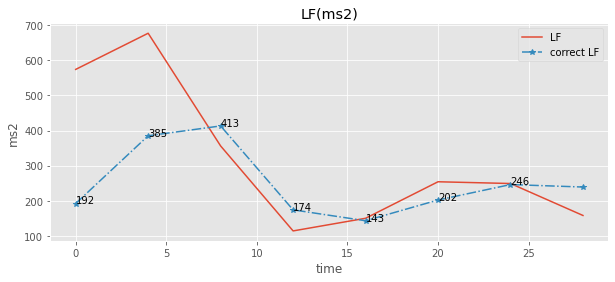

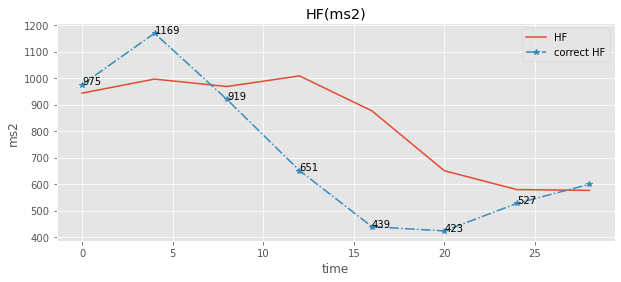

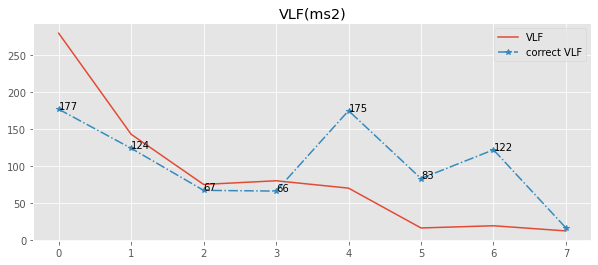

In [35]:
'''
Plot every subject's HRV metries change in each window slice.
Also verify the editing of interbeat intervals method
'''


num_window = int((end_sec-start_sec)/step_sec)
time_axis = np.arange(start_sec, end_sec, step_sec)



plt.figure(figsize=(10,4))
plt.title('LF(ms2)')
plt.plot(time_axis, vital_sign['LF'], label='LF')
plt.plot(time_axis, vital_sign['correct LF'], marker='*', ls='-.', label='correct LF')
plt.ylabel('ms2')
plt.xlabel('time')

plt.legend()

for i in range(num_window):
    plt.text(time_axis[i], vital_sign['correct LF'][i], str(vital_sign['correct LF'][i]), color='black')
    


plt.figure(figsize=(10,4))
plt.title('HF(ms2)')
plt.plot(time_axis, vital_sign['HF'], label='HF')
plt.plot(time_axis, vital_sign['correct HF'], marker='*', ls='-.', label='correct HF')
plt.ylabel('ms2')
plt.xlabel('time')
plt.legend()

for i in range(num_window):
    plt.text(time_axis[i], vital_sign['correct HF'][i], str(vital_sign['correct HF'][i]), color='black')



plt.figure(figsize=(10,4))
plt.title('VLF(ms2)')
plt.plot(vital_sign['VLF'], label='VLF')
plt.plot(vital_sign['correct VLF'], marker='*', ls='-.', label='correct VLF')
plt.legend()

for i in range(num_window):
    plt.text(i, vital_sign['correct VLF'][i], str(vital_sign['correct VLF'][i]), color='black')
    


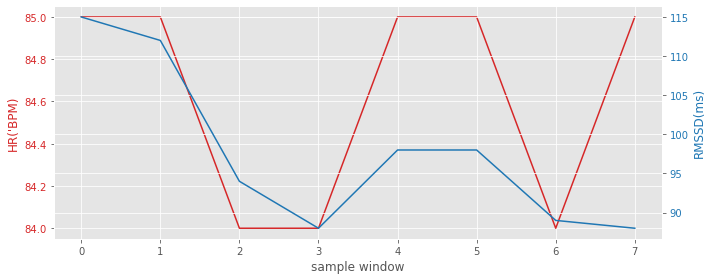

In [32]:
'''
Compare two differnt metric in on time domain
'''
def plot_trend(list1, list2, list1_name='list1', list2_name='list2'):
    fig, ax1 = plt.subplots(figsize=(10,4))
    color = 'tab:red'
    ax1.set_xlabel('sample window')
    ax1.set_ylabel(list1_name, color=color)
    ax1.plot(list1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel(list2_name, color=color)  # we already handled the x-label with ax1
    ax2.plot(list2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped



'''Plot HR and RMSSD'''
plot_trend(vital_sign['correct HR'], vital_sign['correct RMSSD'], "HR('BPM)", "RMSSD(ms)")
